In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
PATH="C:\Data_jupyter\AV_Digit_recog\\"
sz=28
bs=58

In [3]:
label_csv=f'{PATH}train.csv'
n=len(list(open(label_csv)))-1


In [4]:
val_idxs=get_cv_idxs(n)  #validation

In [5]:
label_df = pd.read_csv(label_csv)

In [6]:
label_df.head()

,filename,label
0,0.png,4
1,1.png,9
2,2.png,1
3,3.png,7
4,4.png,3


In [7]:
stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))

In [8]:
def get_data(sz,bs):
    tfms= tfms_from_stats(stats,sz,aug_tfms=transforms_basic,max_zoom=1.05)
    data=ImageClassifierData.from_csv(PATH,'train',f'{PATH}train.csv',test_name='test',val_idxs=val_idxs,tfms=tfms,bs=bs)
    return data


In [9]:
data=get_data(28,bs)

In [10]:
fn=PATH+data.trn_ds.fnames[0]; fn

'C:\\Data_jupyter\\AV_Digit_recog\\train\\0.png'

In [11]:
img=PIL.Image.open(fn); img

In [12]:
img.size

(28, 28)

In [13]:
len(data.trn_ds), len(data.test_ds)

(39200, 21000)

In [14]:
len(data.classes)

10

In [15]:
data.classes

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [16]:
class SimpleNet(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        for l in self.layers:
            l_x = l(x)
            x = F.relu(l_x)
        return F.log_softmax(l_x, dim=-1)

In [17]:
learn = ConvLearner.from_model_data(SimpleNet([28*28*3, 40,10]), data)

In [18]:
learn, [o.numel() for o in learn.model.parameters()]

(SimpleNet(
   (layers): ModuleList(
     (0): Linear(in_features=2352, out_features=40, bias=True)
     (1): Linear(in_features=40, out_features=10, bias=True)
   )
 ), [94080, 40, 400, 10])

In [19]:
learn.summary()

OrderedDict([('Linear-1',
              OrderedDict([('input_shape', [-1, 2352]),
                           ('output_shape', [-1, 40]),
                           ('trainable', True),
                           ('nb_params', 94120)])),
             ('Linear-2',
              OrderedDict([('input_shape', [-1, 40]),
                           ('output_shape', [-1, 10]),
                           ('trainable', True),
                           ('nb_params', 410)]))])

In [20]:
learn.lr_find(end_lr=100)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 88%|████████████████████████████████████████████████████████████▉        | 597/676 [00:09<00:01, 62.91it/s, loss=2.93]


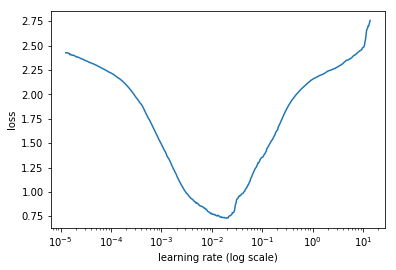

In [21]:
learn.sched.plot()

In [23]:
%time learn.fit(1e-2, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.345005   0.292371   0.913363  
    1      0.315069   0.243295   0.925919                                                                              

Wall time: 26.3 s


[0.24329494, 0.9259189086775296]

In [24]:
%time learn.fit(1e-2, 2, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.184852   0.163955   0.951216  
    1      0.169498   0.155399   0.951734                                                                              

Wall time: 25.9 s


[0.15539932, 0.9517336112163699]

## CNN

In [25]:
class ConvNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(layers[i], layers[i + 1], kernel_size=3, stride=2)
            for i in range(len(layers) - 1)])
        self.pool = nn.AdaptiveMaxPool2d(1)
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        for l in self.layers: x = F.relu(l(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [31]:
learn = ConvLearner.from_model_data(ConvNet([3, 20, 40, 80], 10), data)

In [27]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 28, 28]),
                           ('output_shape', [-1, 20, 13, 13]),
                           ('trainable', True),
                           ('nb_params', 560)])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 20, 13, 13]),
                           ('output_shape', [-1, 40, 6, 6]),
                           ('trainable', True),
                           ('nb_params', 7240)])),
             ('Conv2d-3',
              OrderedDict([('input_shape', [-1, 40, 6, 6]),
                           ('output_shape', [-1, 80, 2, 2]),
                           ('trainable', True),
                           ('nb_params', 28880)])),
             ('AdaptiveMaxPool2d-4',
              OrderedDict([('input_shape', [-1, 80, 2, 2]),
                           ('output_shape', [-1, 80, 1, 1]),
                           ('nb_params', 0)])),
             ('Linear-5',
              OrderedDict

In [28]:
learn.lr_find(end_lr=100)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 89%|█████████████████████████████████████████████████████████████▎       | 601/676 [00:14<00:01, 42.30it/s, loss=3.59]

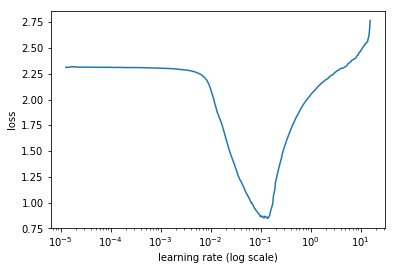

In [29]:
learn.sched.plot()

In [32]:
%time learn.fit(1e-2, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.178241   0.135277   0.957148  
    1      0.116115   0.107052   0.96715                                                                               

Wall time: 33.7 s


[0.10705239, 0.9671495613140175]

In [33]:
%time learn.fit(1e-2, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.067429   0.066789   0.979596  
    1      0.052791   0.060783   0.982147                                                                              
    2      0.048384   0.056657   0.983065                                                                              

Wall time: 51.5 s


[0.056656923, 0.9830646806774128]

## Refactored

In [34]:
class ConvLayer(nn.Module):
    def __init__(self, ni, nf):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=3, stride=2)
        
    def forward(self, x): return F.relu(self.conv(x))

In [35]:
class ConvNet2(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.layers = nn.ModuleList([ConvLayer(layers[i], layers[i + 1])
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        for l in self.layers: x = l(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [36]:
learn = ConvLearner.from_model_data(ConvNet2([3, 20, 40, 80], 10), data)

In [37]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 28, 28]),
                           ('output_shape', [-1, 20, 13, 13]),
                           ('trainable', True),
                           ('nb_params', 560)])),
             ('ConvLayer-2',
              OrderedDict([('input_shape', [-1, 3, 28, 28]),
                           ('output_shape', [-1, 20, 13, 13]),
                           ('nb_params', 0)])),
             ('Conv2d-3',
              OrderedDict([('input_shape', [-1, 20, 13, 13]),
                           ('output_shape', [-1, 40, 6, 6]),
                           ('trainable', True),
                           ('nb_params', 7240)])),
             ('ConvLayer-4',
              OrderedDict([('input_shape', [-1, 20, 13, 13]),
                           ('output_shape', [-1, 40, 6, 6]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 40, 6, 6]),
                 

In [38]:
%time learn.fit(1e-2, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.177381   0.144872   0.954805  
    1      0.109779   0.104776   0.966027                                                                              

Wall time: 33.6 s


[0.10477581, 0.9660273413589063]

In [39]:
%time learn.fit(1e-2, 2, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.070303   0.061723   0.979082  
    1      0.060987   0.055631   0.982245                                                                              

Wall time: 34.4 s


[0.055631224, 0.9822448771387762]

## BatchNorm

In [40]:
class BnLayer(nn.Module):
    def __init__(self, ni, nf, stride=2, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=kernel_size, stride=stride,
                              bias=False, padding=1)
        self.a = nn.Parameter(torch.zeros(nf,1,1))
        self.m = nn.Parameter(torch.ones(nf,1,1))
        
    def forward(self, x):
        x = F.relu(self.conv(x))
        x_chan = x.transpose(0,1).contiguous().view(x.size(1), -1)
        if self.training:
            self.means = x_chan.mean(1)[:,None,None]
            self.stds  = x_chan.std (1)[:,None,None]
        return (x-self.means) / self.stds *self.m + self.a

In [41]:
class ConvBnNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i + 1])
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l in self.layers: x = l(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [42]:
learn = ConvLearner.from_model_data(ConvBnNet([10, 20, 40, 80, 160], 10), data)

In [43]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 28, 28]),
                           ('output_shape', [-1, 10, 28, 28]),
                           ('trainable', True),
                           ('nb_params', 760)])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 10, 28, 28]),
                           ('output_shape', [-1, 20, 14, 14]),
                           ('trainable', True),
                           ('nb_params', 1800)])),
             ('BnLayer-3',
              OrderedDict([('input_shape', [-1, 10, 28, 28]),
                           ('output_shape', [-1, 20, 14, 14]),
                           ('nb_params', 0)])),
             ('Conv2d-4',
              OrderedDict([('input_shape', [-1, 20, 14, 14]),
                           ('output_shape', [-1, 40, 7, 7]),
                           ('trainable', True),
                           ('nb_params', 7200)])),
             ('BnLayer-5',
              OrderedDict([

In [44]:
%time learn.fit(3e-2, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.089185   0.063716   0.980412  
    1      0.070952   0.061044   0.982347                                                                              

Wall time: 1min 42s


[0.06104413, 0.9823468971346956]

In [45]:
%time learn.fit(1e-1, 4, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.052634   0.047109   0.985309  
    1      0.05002    0.038694   0.989186                                                                              
    2      0.02449    0.033144   0.990308                                                                              
    3      0.029354   0.035627   0.987656                                                                              

Wall time: 3min 16s


[0.035627387, 0.9876555804937767]

## DeepBatch Norm

In [46]:
class ConvBnNet2(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([BnLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2 in zip(self.layers, self.layers2):
            x = l(x)
            x = l2(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [48]:
learn = ConvLearner.from_model_data(ConvBnNet2([10, 20, 40, 80, 160], 10), data)

In [49]:
%time learn.fit(1e-2, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.088397   0.07337    0.977038  
    1      0.0542     0.046623   0.986737                                                                              

Wall time: 3min 30s


[0.04662336, 0.9867374005305038]

In [50]:
%time learn.fit(1e-2, 2, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.029672   0.028086   0.991328  
    1      0.022927   0.027949   0.991532                                                                              

Wall time: 3min 31s


[0.027948828, 0.9915323403387065]

## Resnet

In [51]:
class ResnetLayer(BnLayer):
    def forward(self, x): return x + super().forward(x)

In [52]:
class Resnet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [53]:
learn = ConvLearner.from_model_data(Resnet([10, 20, 40, 80, 160], 10), data)

In [54]:
wd=1e-5

In [55]:
%time learn.fit(1e-2, 2, wds=wd)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.0869     0.078578   0.977446  
    1      0.053348   0.048645   0.986424                                                                              

Wall time: 5min 20s


[0.0486445, 0.9864240534001808]

In [56]:
%time learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2, wds=wd)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.024156   0.034243   0.988778  
    1      0.024588   0.039226   0.989186                                                                              
    2      0.01323    0.031249   0.99092                                                                               
    3      0.023614   0.039511   0.989186                                                                              
    4      0.017122   0.042898   0.98888                                                                               
    5      0.007832   0.02877    0.991634                                                                              
    6      0.005779   0.025853   0.992451                                                                              

Wall time: 18min 58s


[0.025853053, 0.9924505203019791]

In [57]:
learn.save('Resnet_edit_MNIST')

In [60]:
learn.load('Resnet_edit_MNIST')

In [61]:
log_preds= learn.predict(data.test_ds)

In [62]:
probs=np.exp(log_preds)
len(probs)

21000

In [63]:
ds = pd.DataFrame()


In [64]:
ds.insert(0,'label',np.argmax(probs,axis=1))
ds.head()

,label
0,4
1,0
2,9
3,7
4,9


In [65]:
ds.insert(0,'filename',[o[5:] for o in data.test_ds.fnames])

In [66]:
ds.head()

,filename,label
0,49000.png,4
1,49001.png,0
2,49002.png,9
3,49003.png,7
4,49004.png,9


In [68]:
Subm=f'{PATH}subm/'
ds.to_csv(f'{Subm}submission_new.csv',index=False)

## Resnet 2

In [69]:
class Resnet2(nn.Module):
    def __init__(self, layers, c, p=0.5):
        super().__init__()
        self.conv1 = BnLayer(3, 16, stride=1, kernel_size=7)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        self.drop = nn.Dropout(p)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.drop(x)
        return F.log_softmax(self.out(x), dim=-1)

In [70]:
learn = ConvLearner.from_model_data(Resnet2([16, 32, 64, 128, 256], 10, 0.2), data)

In [71]:
wd=1e-6

In [72]:
%time learn.fit(1e-2, 2, wds=wd)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.093219   0.0725     0.982449  
    1      0.054832   0.048395   0.985921                                                                              

Wall time: 8min 55s


[0.04839536, 0.9859212405631503]

In [73]:
%time learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2, wds=wd)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.024669   0.030053   0.99092   
    1      0.02222    0.031301   0.990614                                                                              
    2      0.014856   0.029318   0.991634                                                                              
    3      0.026035   0.046511   0.987962                                                                              
    4      0.012757   0.031039   0.991838                                                                              
    5      0.011914   0.034668   0.991328                                                                              
    6      0.006623   0.027141   0.993063                                                                              

Wall time: 31min 15s


[0.027141413, 0.9930626402774944]